### Simulated Annealing to approximate maximum number of Value Networks in Lattice Network

In this notebook the method to approximate the maximum number of value networks in the lattice network is programmed. The code for the SA Algorthim is called "SA" and is made using the cython functions.

In [1]:
%load_ext Cython


In [2]:
%%cython
cimport cython
import heapq
import numpy as np
cimport numpy as np
import networkx as nx
from scipy.linalg import toeplitz
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import timeit

cpdef tuple initialize_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # init graph
    G = nx.grid_2d_graph(L,L, periodic=True)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
    
    # adjency matrix
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cpdef tuple initialize_diagonal_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # init graph
    G = nx.grid_2d_graph(L,L, periodic=True)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
    
    # adjency matrix
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cdef np.ndarray neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    cdef np.ndarray nb = np.where(A[node]==1)[1]
    return nb

cdef np.ndarray init_V(int states, int option):
    '''
    Interaction matrix initialization
    Options:
    - 1: Standard Q-Potts model V matrix
    - 2: Non-directional Value Chain encoding
    - 3: Path 5 states
    '''
    assert states > 1, 'number of states needs to be more than 1'
    cdef np.ndarray V

    if option == 1:
        V = np.identity((states))
        if states == 2:
            V = np.array([[0, 1],\
                          [1, 0]])
        
    if option == 2:
        if states == 2: # A <-> A , B <-> B
            V = np.array([[0, 1],\
                          [1, 0]])
        else:
            first_row = np.zeros(states)
            first_row[1] = 1
            first_col = np.zeros(states)
            first_col[1] = 1

            V = toeplitz(first_col, first_row)

    if option == 3:
        V = np.array([[0, 1, 1, 1, 1],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0]])
    return V

cdef float hamiltonian(G, int node, np.ndarray nb, np.ndarray V):
    '''
    Hamiltonian function: Calculate the energy for each bond of a single node
    , return the sum of these energies

    H: Hamiltonian
    cur_node: investigated current node
    cur_nb: investigated current neighbor
    kronecker (not used): 1 if two nodes are in same state
    '''
    cdef float H = 0
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int kronecker
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        kronecker = 0
        
        # check if states are the same
        H -= V[cur_node, cur_nb]
    return H
    
cdef metropolis(G, A, V, int states, float beta, int time, float system_hamiltonian):
    '''
    Performs all metropolis algorithm steps.
    
    Difference in energy is - (H2 (=new state) - H1 (=old state)) .
    System hamiltonian and magnetization is changed.
    '''
    cdef int rand_node
    cdef int spin
    cdef float dE = 0
    cdef int rand_state
    cdef float p
    cdef float H1 
    cdef float H2
    cdef list sh = []
    cdef list fm = []

    fm.append(G.mean())
    cdef list history_arr = []
    
    for t in range(time):    
        for i in range(len(G)):
            # pick random node
            rand_node = np.random.randint(len(G)-1)
            spin = G[rand_node]
            
            rand_state = np.random.randint(states)
            while rand_state == spin:
                rand_state = np.random.randint(states)
            
            # calculate hamiltonian for current configuration
            nb = neighbors(A, rand_node)
            H1 = hamiltonian(G, rand_node, nb, V)
                        
            # calculate hamiltonian for new configuration
            G_copy = G.copy()
            G_copy[rand_node] = rand_state
            H2 = hamiltonian(G_copy, rand_node, nb, V)
            
            # calculate energy difference
            dE = (H2 - H1)
                        
            # energy may always be decreased
            if dE <= 0:
                p = 1   
                
            # probability proportional to Boltzmann distribution.
            else: 
                p = np.exp(-beta*dE)
                
            # energy is increased with probability
            if np.random.random() <= p:
                G[rand_node] = rand_state
                system_hamiltonian += dE
                
            # change configuration back to the original
            else: 
                G[rand_node] = spin
    
            sh.append(system_hamiltonian)
            fm.append(G.mean())
            history_arr.append(G.copy())

    return G, sh, history_arr

### Analysis functions
cdef float full_hamiltonian(G, A, V):
    '''
    Returns the energy state of the system.
    '''
    cdef float system_hamiltonian = 0 
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_hamiltonian += hamiltonian(G, G[i], nb, V)
    return 0.5 * system_hamiltonian

### Satisfaction functions
cdef float full_satisfaction(G, A, V):
    'returns average satisfaction of the nodes'
    cdef float system_satisfaction = 0
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_satisfaction += local_satisfaction(G, G[i], nb, V)
    return system_satisfaction * 0.5

cdef float local_satisfaction(G, int node, np.ndarray nb, np.ndarray V):
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int s = 0
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        if V[cur_node, cur_nb] == 0:
            s -=0
        else: 
            s += 1  
    return s

### Find value chain functions
cdef local_chain_satisfactions(G, A, V):
    cdef np.ndarray nb
    cdef satisfaction = 0
    cdef G_satisfaction = []
    cdef int node_i = 0
    cdef int state_node = 0 

    for node_i, state_node in enumerate(G):
        satisfaction = 0
        nb = neighbors(A, node_i)
        for i in range(len(nb)):
            if V[int(state_node), int(G[nb[i]])] == 1:
                satisfaction += 1
            else:
                satisfaction -= 1
                
        G_satisfaction.append(satisfaction)
    return G_satisfaction

### Simulation functions
def init_V_py(states, option):
    V = init_V(states, option)
    return V

def check_local(G, A, V):
    G_satisfaction = local_chain_satisfactions(G, A, V)
    # print(np.array(G_satisfaction).reshape(10,10))
    return np.mean(G_satisfaction)

def put_in_dataframe(fm, system_hamiltonian, A, V):
    '''
    Save data in convenient manner using pandas dataframe for each run, which is stored in a dictionary.
    '''
    df = pd.DataFrame(data=fm)
    # put energy value of timestep in last column
#     df.loc[:, fm[0].shape[0]+1] = check(fm, A, V) # complete Value Chains
    df.loc[:, fm[0].shape[0]+2] = system_hamiltonian # phase of system
    df.loc[:, fm[0].shape[0]+3] = check_local(fm[-1], A, V) # local satisfaction
    return df

def simulate(T, states, V, timesteps):
    lattice_size = 10
    G, A = initialize_lattice(lattice_size, states)
    G_init = G.copy()
    sh = full_hamiltonian(G,A,V)
    beta = 1 / T
    M, system_hamiltonian, fm = metropolis(G, A, V, states, beta, timesteps, sh)
    return G_init, V, system_hamiltonian, A, fm

def perform_tests(temperatures, states, samples, V, timesteps):
    '''
    Perform multiple simulations with different input parameters.
    Saves the system-hamiltonian per step of multiple runs.
    '''
    l = len(temperatures) * len(states) * len(samples)
    i = 0

    runs = {}
    for state in states:
        for temp in temperatures:
            print(temp)
            for run in samples:
                G_init, V, system_hamiltonian, A, fm = simulate(temp, state, V, timesteps)
                df = put_in_dataframe(fm, system_hamiltonian, A, V)
                runs[f'run{state,temp,run}'] = df

                i += 1
    return runs

# This function is called 'VN_counter2' in vc.pyx
def VN_counter(G, A, V):
    g = nx.from_numpy_matrix(V, create_using=nx.DiGraph)
    g.edges()
    V_mapping = nx.convert.to_dict_of_lists(g)
    
    sorted_items = heapq.nlargest(len(V_mapping), V_mapping.items(), key=lambda x: len(x[1]))
    V_mapping = dict(sorted_items)
        
    # first make a dictionary with nodes that are satisfying the requirements
    sat_dict = {}
    for key in V_mapping:
        start_nodes = np.where(G==key)[0]
        sat_list = []
        for node in start_nodes: 
            nb = neighbors(A, node)
            node_struct = []
            for i in range(len(nb)):
                node_struct.append(G[nb[i]])
            if all(elem in node_struct for elem in V_mapping[key]):
                sat_list.append(node)
                
        sat_dict[key] = sat_list
        
#     print(sat_dict)
        
    # second check if the full Value Network is satisfied
    nodes_checked = []
    VN_counter = 0
    meets_req = []
    meets_req2 = []

    for key in sat_dict:
        requirements = np.zeros((V.shape[0]))
        
        # add node to VN
        for node in sat_dict[key]:
            requirements = np.zeros((V.shape[0]))
            meets_req2.append(node)
            meets_req.append(node)
            requirements[int(G[node])] = 1
            
            if node in nodes_checked:
                continue
            
            # see if nb are in VN
            nb = neighbors(A, node)
            for i in range(len(nb)):
                if nb[i] in sat_dict[int(G[nb[i]])] and nb[i] not in nodes_checked and G[int(nb[i])] in V_mapping[int(G[node])]:                
                    requirements[int(G[nb[i]])] = 1
                    meets_req.append(nb[i])
                    
            if requirements.all() == 1:
                VN_counter += 1
                requirements = np.zeros((V.shape[0]))
                
                without_doubles = []
                for nd in meets_req:
                    if requirements[int(G[nd])] == 0:
                        without_doubles.append(nd)
                        requirements[int(G[nd])] = 1
                        
                nodes_checked.extend(without_doubles)
                meets_req = []
                  
            else:
                for x in range(0, len(meets_req)-1):
                    nb2 = neighbors(A, meets_req[x])
                    for j in range(len(nb2)):
                        if nb2[j] != node and nb2[j] in sat_dict[int(G[nb2[j]])] and G[int(nb2[j])] in V_mapping[int(G[meets_req[x]])] and nb2[j] not in nodes_checked:                        
                            if requirements[int(G[nb2[j]])] != 1:
                                meets_req2.append(meets_req[x])
                                meets_req2.append(nb2[j])
                                requirements[int(G[nb2[j]])] = 1
                                             
                        if requirements.all() == 1:
                            VN_counter += 1                                                    
                            requirements_test = np.zeros((V.shape[0]))
                            nodes_checked.extend(meets_req2)
                            requirements = np.zeros((V.shape[0]))
                            break
            meets_req = []
            meets_req2 = []                    
    return VN_counter, nodes_checked

def BruteForce(samples, V_list, V_dict):
    '''
    Test the maximum possible VNs in lattice
    '''
    L = 10
    G = nx.grid_2d_graph(L,L, periodic=True)
    length = len(G.nodes())
    
    # adjency matrix
    A = nx.adjacency_matrix(G).todense()
    
    count_dict = {}
    sol_dict = {}
    sol_lists = {}

    for v in V_list:
        print(v)
        if v == 0:
            samples = 1000
        else:
            samples = 1000000
        highest_count = 0
        best_sol = 0
        
        solutions = []
        V = V_dict[f'{v}']
        state = V.shape[0]
        G_init, V, system_hamiltonian, A, fm = simulate(1, state, V, 1)
    
        for i in range(samples):
            G_rand = np.random.randint(low=0, high=state, size=length)
            
            count = VN_counter(G_rand, A, V)
            solutions.append(count)
            
            if count[0] > highest_count:
                highest_count = count[0]
                best_sol = G_rand
        
        count_dict[f'VN: {v} States: {state}'] = highest_count
        sol_dict[f'VN: {v} States: {state}'] = best_sol
        sol_lists[f'VN: {v} States: {state}'] = solutions
        
    return count_dict, sol_dict, sol_lists

def SA(V_list, V_dict, kmax=10000):
    '''
    Using this function the simulated algorithm runs. 
    The input is a list which value networks to use from the value network dictionary.
    '''
    results_dict = {}
    
    # the rate and temperature are set low, this is to make sure the result does not stay in a local optimum
    rate = 0.0000001
    temperature=10000000000000000
    cooling = lambda x, k, rate: x/(1 + rate * k**2)

    # initialise a lattice graph and adjacency matrix
    L = 10
    G = nx.grid_2d_graph(L,L, periodic=True)
    length = len(G.nodes())
    
    # adjency matrix
    A = nx.adjacency_matrix(G).todense()

    for v in V_list:
        V = V_dict[f'{v}']
        state = V.shape[0]
        
        # t trials to make sure the results of the SA are stable
        for t in range(0, 10):
            print(f'V={v}T={t}')
            solutions = []

            # fill graph with random states
            G0 = np.random.randint(low=0, high=state, size=length)
            
            # calculate the score which is the initial best score
            best_score = VN_counter(G0, A, V)[0]
            current = G0
            
            # keep track of all solutions
            solutions.append(best_score)
            k = 0

            temperature = 10000000000000000
            while abs(temperature) > 0.00001:
                # pick rand node
                node = np.random.randint(0, L*L)

                # new state for neigbour; snew
                proposal_graph = current.copy()
                snew = np.random.randint(0, state)
                proposal_graph[node] = snew
                proposal_score = VN_counter(proposal_graph, A, V)[0]
    #             print(VN_counter(proposal_graph, A, V))

                # in case of new best score save score and graph
                best_graph = 0
                solutions.append(proposal_score)
                if proposal_score > best_score:
                    current = proposal_graph.copy()
                    best_graph = proposal_graph
                    best_score = proposal_score
                    print("best score = ", best_score)

                # change temperature according to cooling schedule
                temperature = (1 + (proposal_score - best_score) / (proposal_score + 1))
                temperature *= cooling(abs(temperature), k, rate)

                k += 1
                
                # if the max iterations is reached break the for loop and start over
                if k > kmax:
                    print("Annealing finished")
                    break
            results_dict[f'score{v}trial{t}'] = solutions
            results_dict[f'graph{v}trial{t}'] = best_graph
            solutions = []
            print("k", k)
    return results_dict

In [6]:
V_dict = pickle.load(open("experiments_with_V/V_matrices.p", "rb"))
V_list = [0, 1, 3, 4, 6, 9, 10, 11]
results_dict = SA(V_list, V_dict, kmax=10000)

V=0T=0
best score =  44
best score =  45
best score =  46
best score =  47
best score =  48
Annealing finished
k 10001
V=0T=1
best score =  45
best score =  46
best score =  47
best score =  48
best score =  49
Annealing finished
k 10001
V=0T=2
best score =  43
best score =  44
best score =  45
best score =  46
best score =  47
best score =  48
best score =  49
Annealing finished
k 10001
V=0T=3
best score =  40
best score =  41
best score =  42
best score =  43
best score =  44
best score =  45
best score =  46
best score =  47
Annealing finished
k 10001
V=0T=4
best score =  40
best score =  41
best score =  42
best score =  43
best score =  44
best score =  45
best score =  46
best score =  47
best score =  48
Annealing finished
k 10001
V=0T=5
best score =  42
best score =  43
best score =  44
best score =  45
best score =  46
best score =  47
best score =  48
best score =  49
Annealing finished
k 10001
V=0T=6
best score =  40
best score =  41
best score =  42
best score =  43
best sc

best score =  10
best score =  11
best score =  12
best score =  13
best score =  14
best score =  15
best score =  16
best score =  17
best score =  18
best score =  19
best score =  20
Annealing finished
k 10001
V=4T=9
best score =  6
best score =  8
best score =  9
best score =  10
best score =  11
best score =  12
best score =  13
best score =  14
best score =  15
best score =  16
best score =  17
best score =  18
Annealing finished
k 10001
V=6T=0
best score =  6
best score =  7
best score =  8
best score =  9
best score =  10
best score =  11
best score =  12
best score =  13
best score =  14
best score =  15
best score =  16
Annealing finished
k 10001
V=6T=1
best score =  7
best score =  8
best score =  9
best score =  10
best score =  11
best score =  12
best score =  13
best score =  14
best score =  15
best score =  16
best score =  17
Annealing finished
k 10001
V=6T=2
best score =  3
best score =  4
best score =  5
best score =  6
best score =  7
best score =  8
best score = 

In [44]:
scores = []
for v in V_list:
    best = 0
    score = []
    for t in range(0,10):
        score.append(results_dict[f'score{v}trial{t}'][-1])
        if results_dict[f'score{v}trial{t}'][-1] > best:
            best = results_dict[f'score{v}trial{t}'][-1]
    print(v, best)
    scores.append(score)

0 49
1 28
3 18
4 19
6 18
9 8
10 13
11 3


In [50]:
means = [np.mean(scores[i]) for i in range(8)]
stds = [np.std(scores[i]) for i in range(8)]
means[5] = 5
means[7] = 5

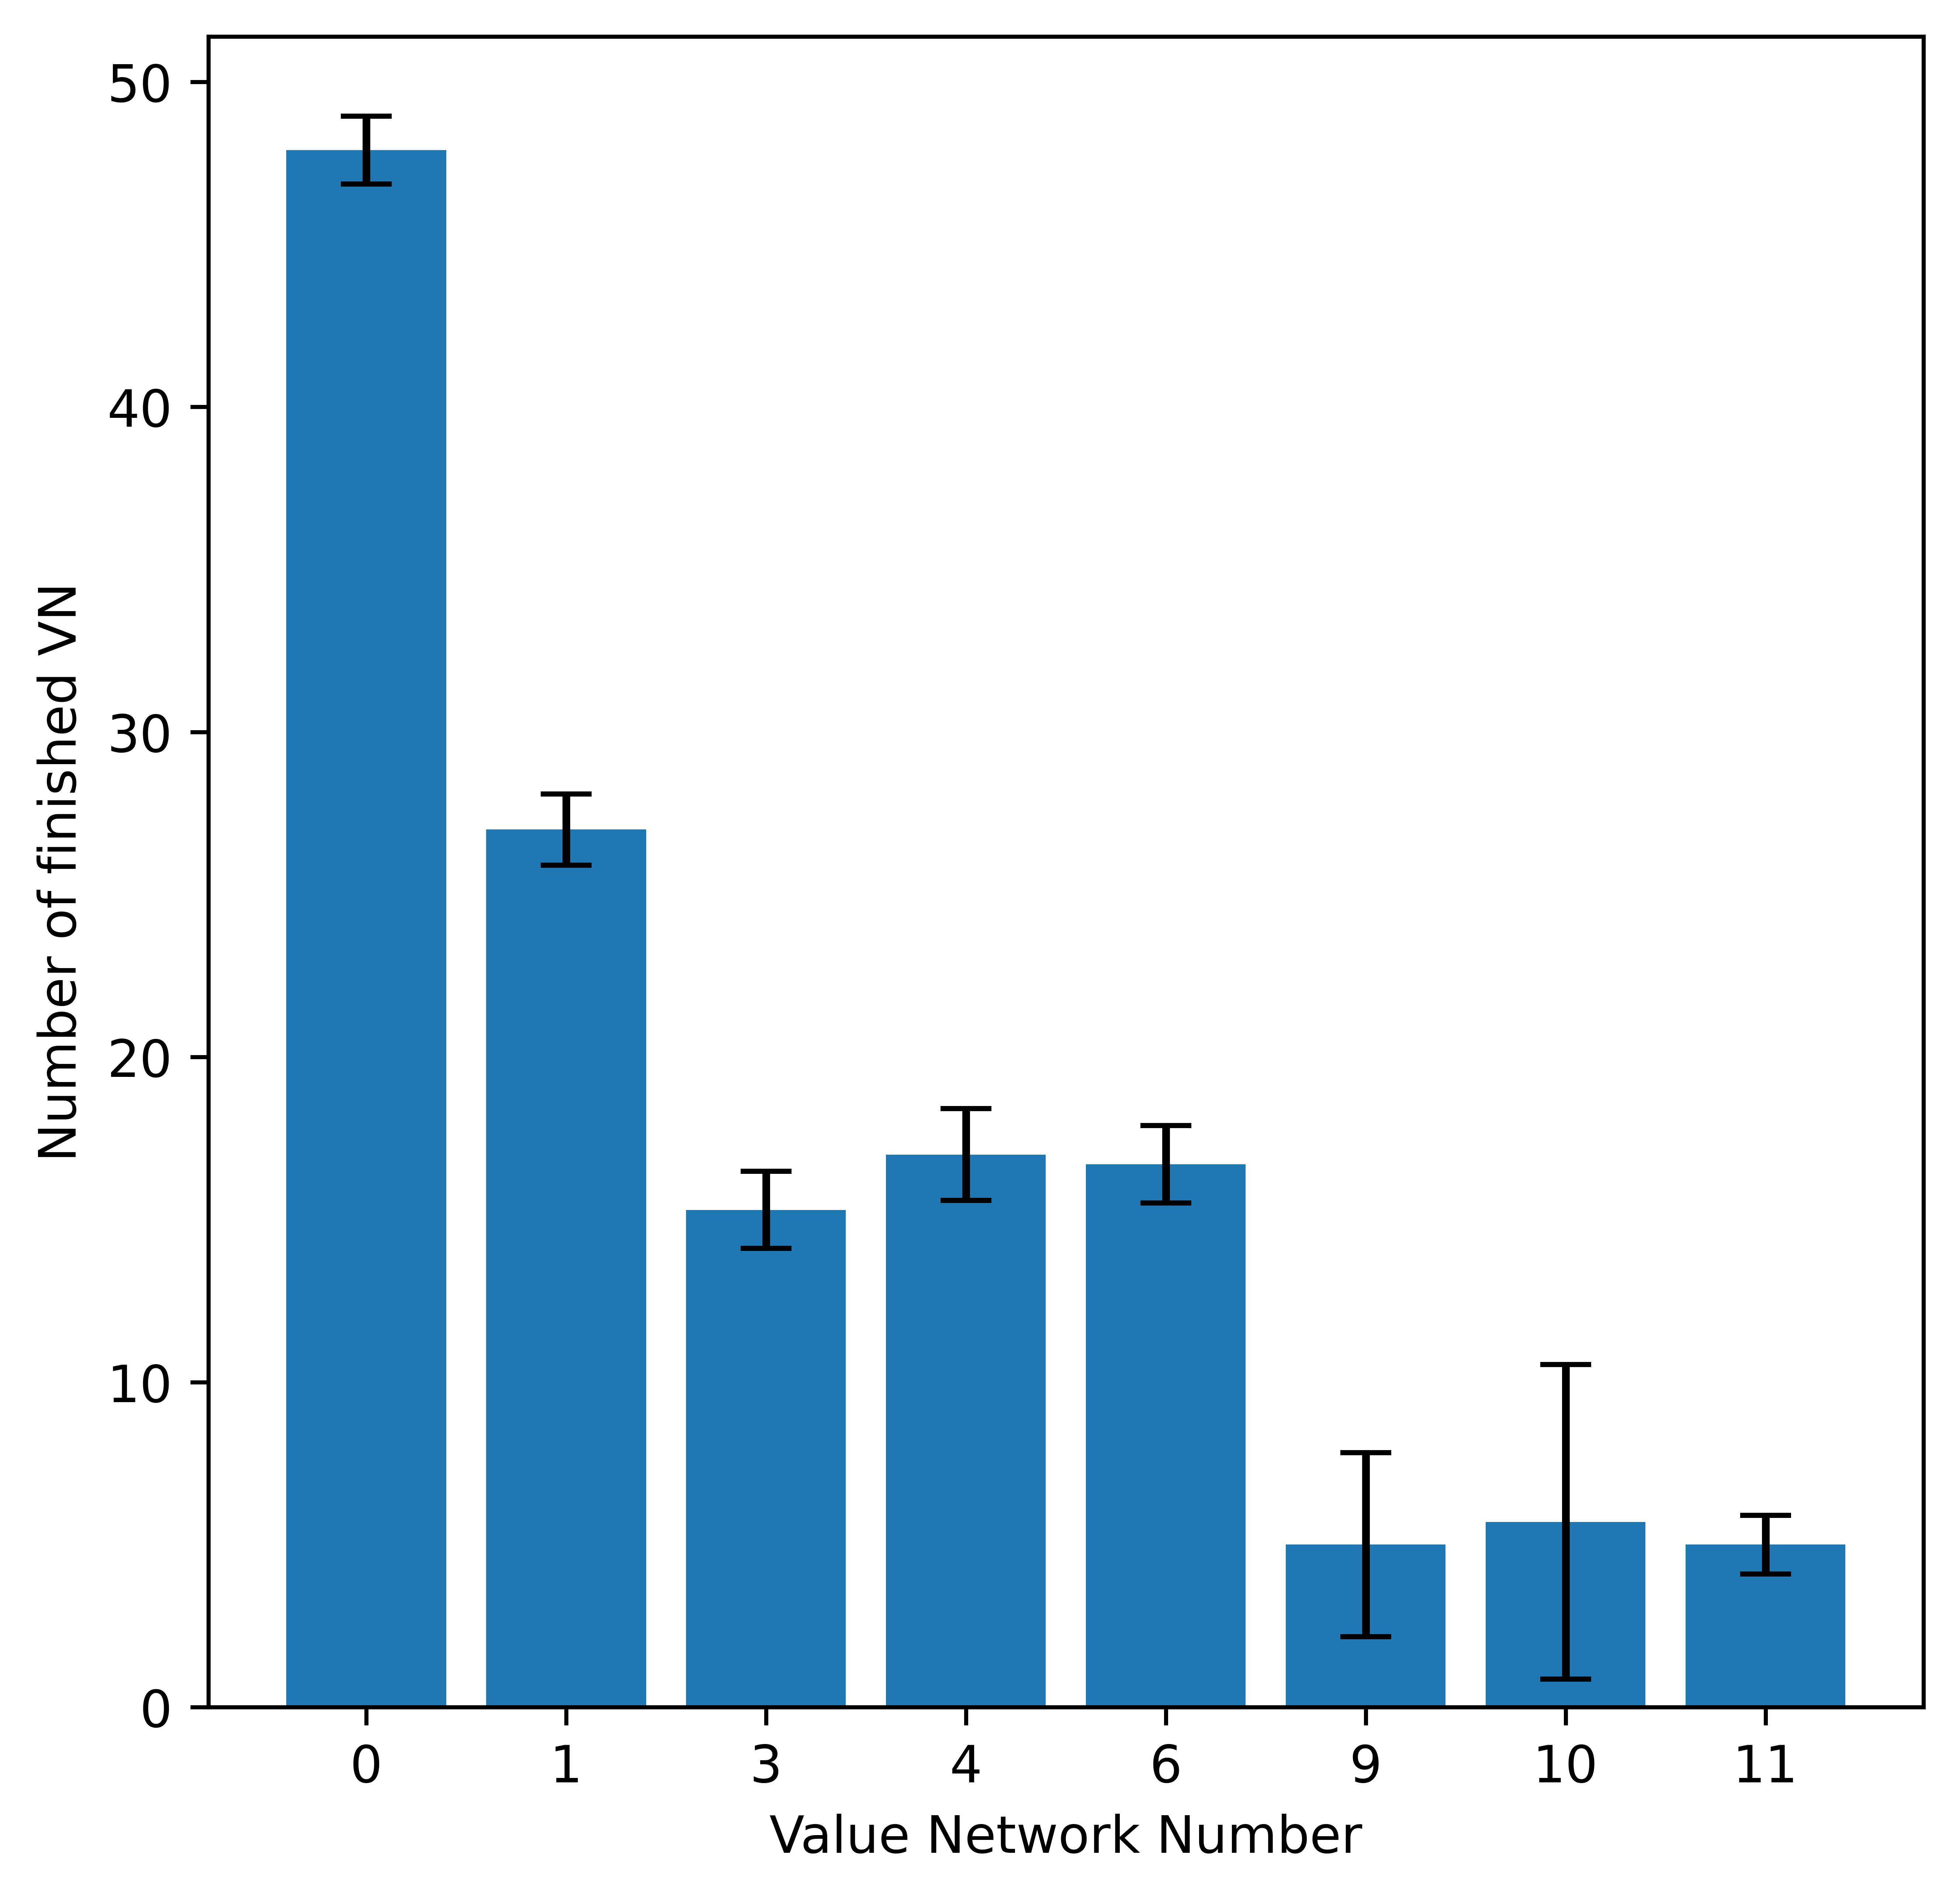

In [54]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=1000)
ax  = plt.gca()
xl = np.array([str(i) for i in V_list], dtype = object)
x = xl
y = means
ax.set_xticks(np.arange(len(V_list)))
ax.set_xticklabels(V_list)
plt.ylabel('Number of finished VN')
plt.xlabel('Value Network Number')
bars = ax.bar(x, y, yerr = stds, linewidth=4.0, capsize = 5)
plt.show()